# **Name: Muhammad Sharjeel**
# **Student Number: 23086732**
# **GitHub Repository: https://github.com/Sharjeel-Analyst/ADS_2**

This report includes a dataset with details of credit card company customers and gives us analysis to uncover different results, such as average credit limit, total credit cards, total visits bank, total visits online, and total calls made. We have done customer segmentation to understand customers' behavior to help a credit card company. We will also explore clustering techniques and make the fitting process in data.

In [35]:
#Libraries import for use
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy.optimize import curve_fit

In [36]:
#Data Loading
data = pd.read_csv("Credit Card Customer Data.csv")
data.head()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3


### VARIABLES DESCRIPTION 

**Avg_Credit_Limit**: Average Credit Card Limit For The Customer

**Total_Credit_Cards**: Total Credit Cards Owned by the Customer

**Total_visits_bank**: Total Number of Bank Visits by the Customer

**Total_visits_online**: Total Visits Online by the Bank Customer

**Total_calls_made**: Total Calls Made by the Customer to the Bank


## DATA PROCESSING AND CLEANING 

In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                660 non-null    int64
 1   Customer Key         660 non-null    int64
 2   Avg_Credit_Limit     660 non-null    int64
 3   Total_Credit_Cards   660 non-null    int64
 4   Total_visits_bank    660 non-null    int64
 5   Total_visits_online  660 non-null    int64
 6   Total_calls_made     660 non-null    int64
dtypes: int64(7)
memory usage: 36.2 KB


In [38]:
#Cheking for Missing Values  
data.isnull().sum()

Sl_No                  0
Customer Key           0
Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64

In [39]:
# check duplicate
data.duplicated().sum()

0

Here is the identification of out liners in each column of data and showing the graphical representation of them in boxplot.

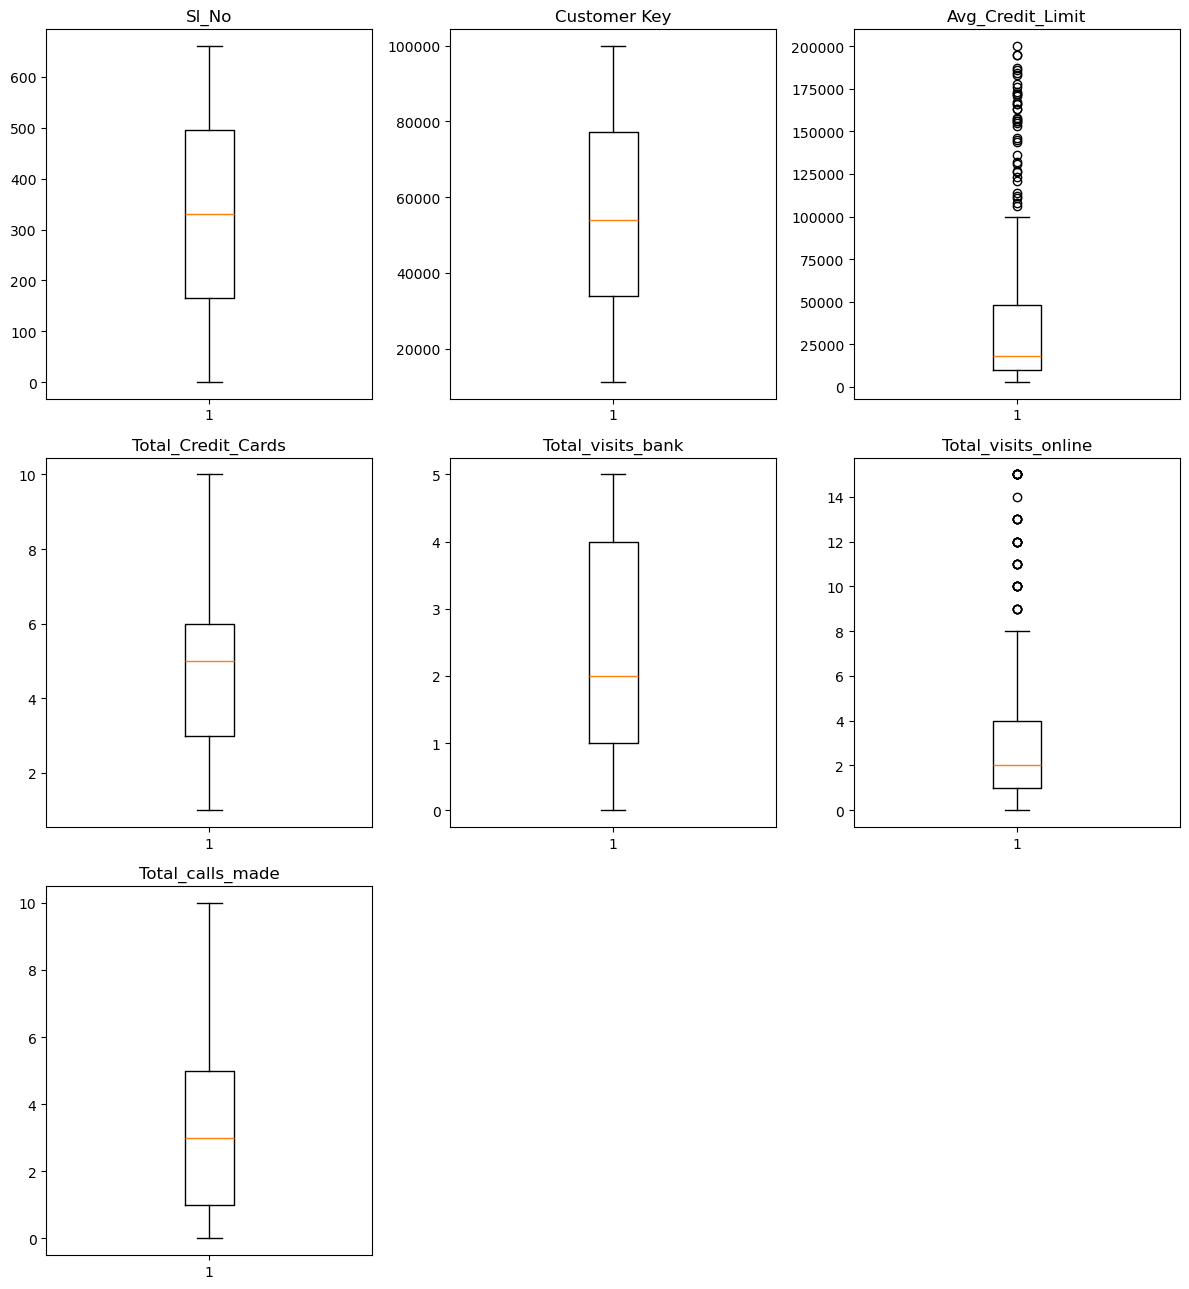

In [40]:
#check outliers

columns = data.columns
fig, axes = plt.subplots(nrows =3, ncols =3, figsize= (12, 13))
axes = axes.flatten()

for i, column in enumerate(columns):
    axes[i].boxplot(data[column])
    axes[i].set_title(column)
    
for j in range(len(columns), len(axes)):
    axes[j].axis('off')
    
plt.tight_layout()
plt.show()

In [41]:
#Dropping outliers
def drop_outliers(df, field_name):
    iqr = 1.5 * (np.percentile(df[field_name], 75) - np.percentile(df[field_name], 25))
    df.drop(df[df[field_name] > (iqr + np.percentile(df [field_name], 75)) ].index, inplace=True) 
    df.drop(df[df[field_name] < (np.percentile(df [field_name], 25) - iqr)].index, inplace=True)

In [42]:
# dropping all the outliers
outliers_cols =['Avg_Credit_Limit', 'Total_visits_online']
    
for col in outliers_cols:
    drop_outliers(data, col)

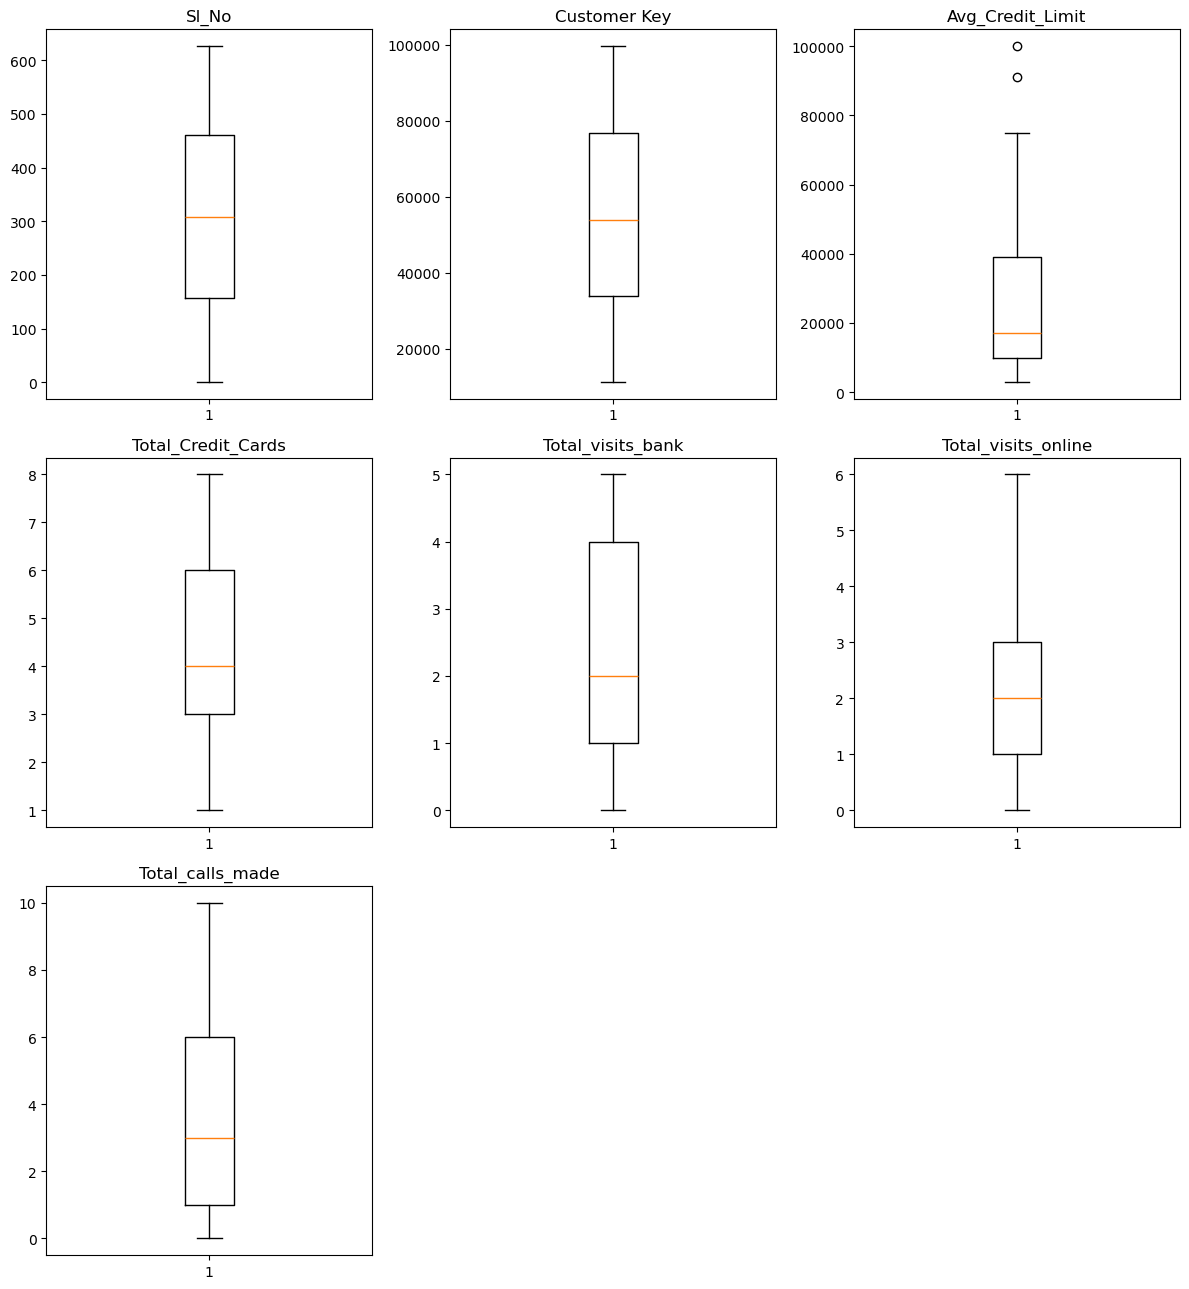

In [43]:
#After dropping outliers distribution of data
columns = data.columns
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 13))
axes = axes.flatten()

for i, column in enumerate(columns):
    axes[i].boxplot(data[column])
    axes[i].set_title(column)

# Hide any extra axes if there are fewer columns than subplot spaces
for j in range(len(columns), len(axes)):
    axes[j].axis('off')
    
plt.tight_layout()
plt.show()

In [44]:
#Selecting Feature for Clustering
X = data.iloc[:,2:]

X

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,100000,2,1,1,0
2,50000,7,1,3,4
3,30000,5,1,1,4
5,20000,3,0,1,8
7,15000,3,0,1,1
...,...,...,...,...,...
608,47000,4,4,1,0
609,38000,4,3,2,0
610,39000,7,2,1,0
611,46000,7,4,1,3


# Explanatory Data Analysis


This data set shows considerable variability across different metrics. Average credit limit and total credit cards are relatively more concentrated around their means, showing less variation among the majority of users. On the other hand, total bank visits, online visits, and calls made show diverse customer interactions.

In [45]:
X.describe().T

,count,mean,std,min,25%,50%,75%,max
Avg_Credit_Limit,610.0,25914.754098,20868.167287,3000.0,10000.0,17000.0,39000.0,100000.0
Total_Credit_Cards,610.0,4.383607,1.878159,1.0,3.0,4.0,6.0,8.0
Total_visits_bank,610.0,2.552459,1.601939,0.0,1.0,2.0,4.0,5.0
Total_visits_online,610.0,1.919672,1.571014,0.0,1.0,2.0,3.0,6.0
Total_calls_made,610.0,3.775410,2.869416,0.0,1.0,3.0,6.0,10.0


In [46]:
data['Total_interaction']= data['Total_calls_made'] + data['Total_visits_online'] + data['Total_visits_bank']

In [47]:
mean_cl = round(data['Avg_Credit_Limit'].mean(), 2)

higher_mean_cl = data[data['Avg_Credit_Limit'] > mean_cl]
below_mean_cl = data[data['Avg_Credit_Limit'] < mean_cl]
print('The number of records higher than mean credit score:', higher_mean_cl.shape[0])
print('The number of records below than mean credit score:', below_mean_cl.shape[0])

The number of records higher than mean credit score: 219
The number of records below than mean credit score: 391


In [48]:
data.head()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,Total_interaction
0,1,87073,100000,2,1,1,0,2
2,3,17341,50000,7,1,3,4,8
3,4,40496,30000,5,1,1,4,6
5,6,58634,20000,3,0,1,8,9
7,8,37376,15000,3,0,1,1,2


In [49]:
data['Total_Credit_Cards'].value_counts().head()

Total_Credit_Cards
4    151
6    116
7     94
5     73
2     64
Name: count, dtype: int64

<Axes: ylabel='count'>

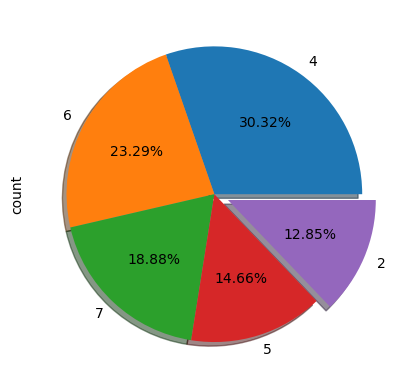

In [50]:
data['Total_Credit_Cards'].value_counts().head().plot(kind='pie',explode=(0,0,0,0,0.1),shadow=True,autopct="%1.2f%%")

This histogram provides a comprehensive view of how average credit limits are distributed across customers and highlights the most common values.

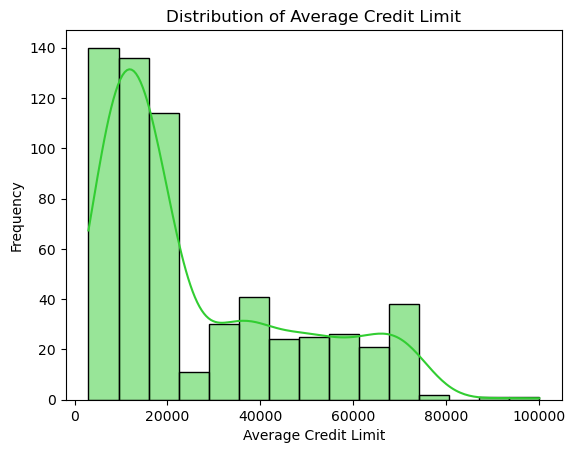

In [51]:
sns.histplot(data['Avg_Credit_Limit'], kde=True,color='limegreen')
plt.title('Distribution of Average Credit Limit')
plt.xlabel('Average Credit Limit')
plt.ylabel('Frequency')
plt.show()

This Scatter plot visually represents the way to analyze the various relationships between various customer metrics and their unique identifier which is the customer key.

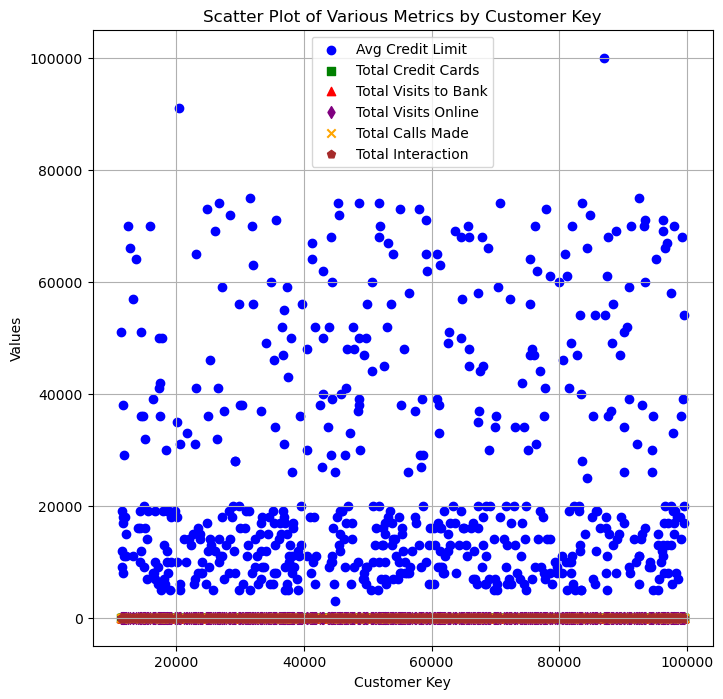

In [52]:
# Creating a figure for the scatter plot
plt.figure(figsize=(8, 8))

# Scatter plot for each metric
plt.scatter(data['Customer Key'], data['Avg_Credit_Limit'], marker='o', label='Avg Credit Limit', color='blue')
plt.scatter(data['Customer Key'], data['Total_Credit_Cards'], marker='s', label='Total Credit Cards', color='green')
plt.scatter(data['Customer Key'], data['Total_visits_bank'], marker='^', label='Total Visits to Bank', color='red')
plt.scatter(data['Customer Key'], data['Total_visits_online'], marker='d', label='Total Visits Online', color='purple')
plt.scatter(data['Customer Key'], data['Total_calls_made'], marker='x', label='Total Calls Made', color='orange')
plt.scatter(data['Customer Key'], data['Total_interaction'], marker='p', label='Total Interaction', color='brown')

# Adding titles and labels
plt.title('Scatter Plot of Various Metrics by Customer Key')
plt.xlabel('Customer Key')
plt.ylabel('Values')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

From this customer correlation heatmap, we can analyze customer behavior and make data-driven decisions to improve credit card selling strategies.

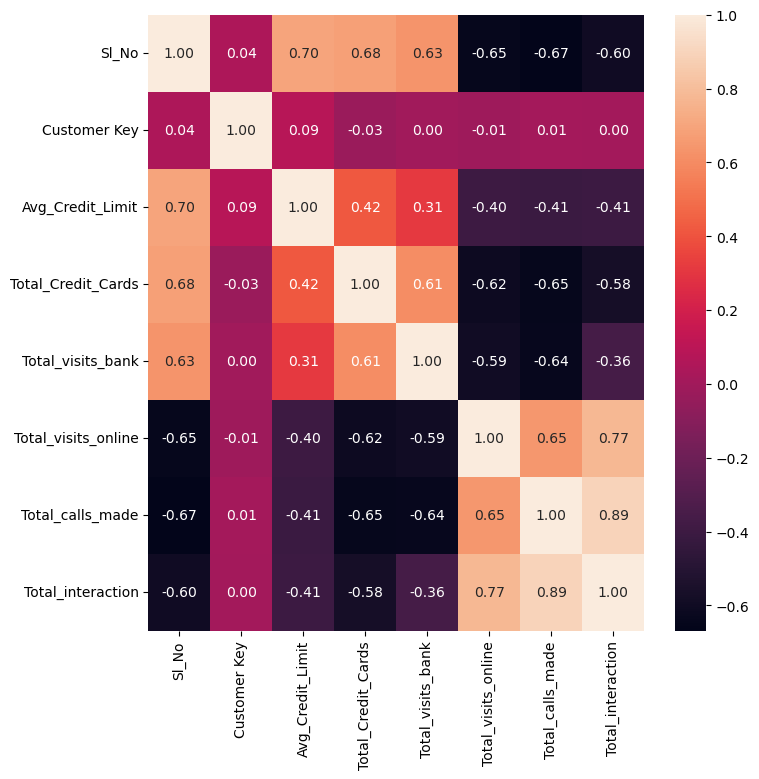

In [53]:
plt.figure(figsize=(8,8))
sns.heatmap(data.corr(), annot=True, fmt='0.2f')
plt.show()

## Normalization (Standardization):

In [54]:
#Variances of Selected Variables
X.var()

Avg_Credit_Limit       4.354804e+08
Total_Credit_Cards     3.527481e+00
Total_visits_bank      2.566209e+00
Total_visits_online    2.468085e+00
Total_calls_made       8.233549e+00
dtype: float64

In [55]:
#The variances are very different from each other
#Standardize Data
sc = MinMaxScaler((0, 1))
X = sc.fit_transform(X)
X[0:5]

array([[1.        , 0.14285714, 0.2       , 0.16666667, 0.        ],
       [0.48453608, 0.85714286, 0.2       , 0.5       , 0.4       ],
       [0.27835052, 0.57142857, 0.2       , 0.16666667, 0.4       ],
       [0.17525773, 0.28571429, 0.        , 0.16666667, 0.8       ],
       [0.12371134, 0.28571429, 0.        , 0.16666667, 0.1       ]])

In [56]:
np.random.seed(50)
kmeans = KMeans(n_clusters=3).fit(X)
print(kmeans.cluster_centers_)
kmeans.labels_

[[0.4040404  0.64718615 0.51414141 0.15151515 0.20151515]
 [0.09269063 0.2007722  0.18828829 0.58933934 0.68873874]
 [0.22908302 0.64285714 0.88315789 0.18070175 0.19736842]]


array([0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 2, 0, 2, 0, 2, 2, 2, 2, 0, 0, 0, 2, 2, 2, 2,
       0, 2, 0, 2, 2, 0, 0, 2, 0, 0, 2, 0, 2, 2, 2, 2, 0, 2, 0, 2, 2, 2,
       2, 2, 2, 2, 0, 0, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 2, 0, 0,
       2, 0, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2,

In [57]:
scaler=StandardScaler()

clusters_kmeans = kmeans.labels_
data["cluster"] = clusters_kmeans
data.head()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,Total_interaction,cluster
0,1,87073,100000,2,1,1,0,2,0
2,3,17341,50000,7,1,3,4,8,0
3,4,40496,30000,5,1,1,4,6,0
5,6,58634,20000,3,0,1,8,9,1
7,8,37376,15000,3,0,1,1,2,0


In [58]:
data["cluster"] = data["cluster"] + 1


In [59]:
data.iloc[:,2:].groupby("cluster").agg(["mean","median"])

Avg_Credit_Limit          Total_Credit_Cards        Total_visits_bank  \
                    mean   median               mean median              mean   
cluster                                                                         
1           42191.919192  45000.0           5.530303    6.0          2.570707   
2           11990.990991  11500.0           2.405405    2.0          0.941441   
3           25221.052632  17000.0           5.500000    6.0          4.415789   

               Total_visits_online        Total_calls_made         \
        median                mean median             mean median   
cluster                                                             
1          3.0            0.909091    1.0         2.015152    2.0   
2          1.0            3.536036    4.0         6.887387    7.0   
3          5.0            1.084211    1.0         1.973684    2.0   

        Total_interaction         
                     mean median  
cluster                           
1                5.494949    6.0  
2               11.364865   11.0  
3                7.473684    8.0

These graphs visually represent the customer segmentation for clustering and show how average credit limit and total credit cards vary in different segments.

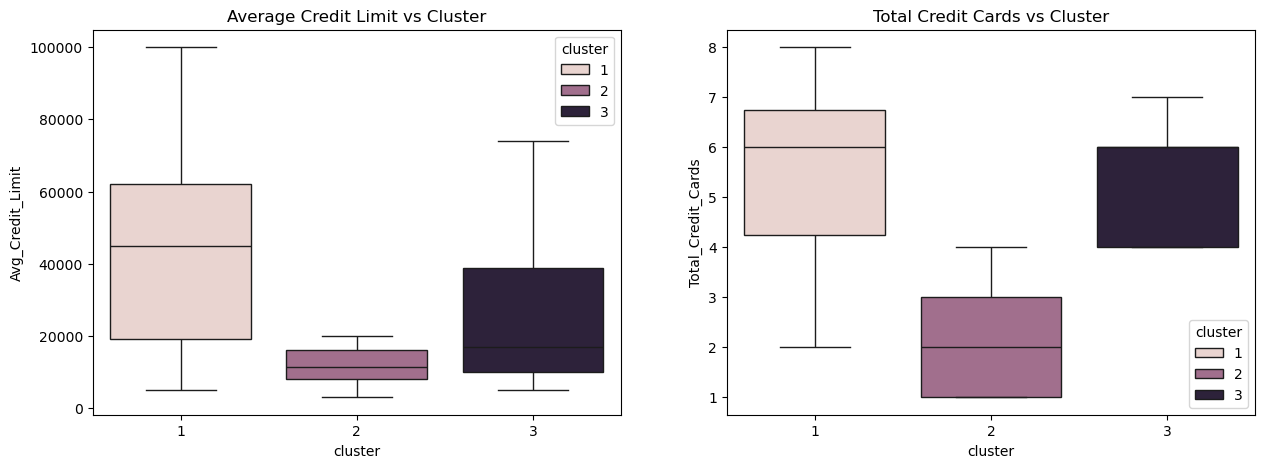

In [60]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))

plt.subplot(1,2,1)
sns.boxplot(data = data, x = "cluster", y = "Avg_Credit_Limit", hue = "cluster");
plt.title("Average Credit Limit vs Cluster")

plt.subplot(1,2,2)
sns.boxplot(data = data, x = "cluster", y = "Total_Credit_Cards", hue = "cluster");
plt.title("Total Credit Cards vs Cluster")

plt.show()

### K-Means Clustering

This resulting graph provides a systematic approach to determining the optimal number of clusters for your data by ensuring meaningful clustering analysis.

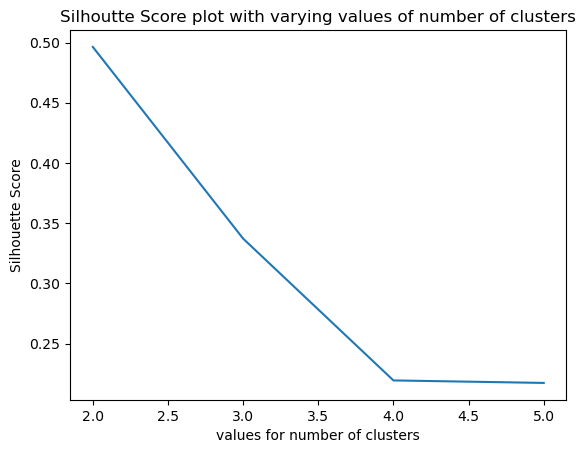

In [61]:
from sklearn.metrics import silhouette_score
sil_score = []
i_range = []
for i in range (2,6):
    kmeans = KMeans(n_clusters=i, random_state = 42).fit(X)
    t = silhouette_score(X, kmeans.labels_)
    sil_score.append(t)
    i_range.append(i)
p = sns.lineplot(x = i_range, y = sil_score)
p.set_xlabel("values for number of clusters")
p.set_ylabel("Silhouette Score")
p.set_title("Silhoutte Score plot with varying values of number of clusters")
plt.show()

This is the essential step in clustering, providing insights into the structure of the dataset by grouping smaller data points together

In [62]:
kmeans = KMeans(n_clusters=3)
# fitting input data
kmeans = kmeans.fit(X)
labels = kmeans.predict(X)
centroids = kmeans.cluster_centers_
centroids

array([[0.31886838, 0.64599483, 0.69664083, 0.16580534, 0.1997416 ],
       [0.09127266, 0.17610837, 0.3       , 0.6408046 , 0.63534483],
       [0.09451778, 0.22830441, 0.06542056, 0.52959502, 0.7411215 ]])

In [63]:
scaller = StandardScaler() 
X_std =scaller.fit_transform(data)

Elbow plots provide a systematic approach to determine the optimal number of clusters for K-mean clustering, by doing effective data segmentation.

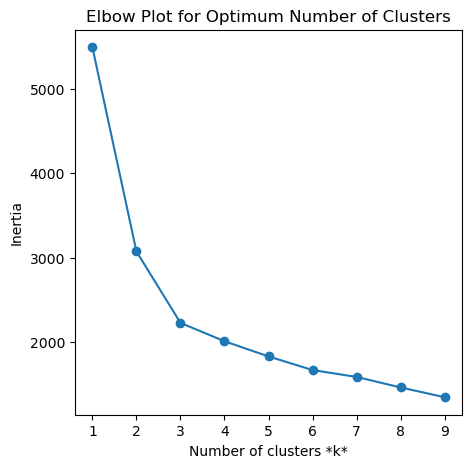

In [64]:
inertias = [] 
list_k = list(range(1, 10))
for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(X_std)
    inertias.append(km.inertia_)
plt.figure(figsize=(5,5))
plt.plot(list_k, inertias, '-o')
plt.title("Elbow Plot for Optimum Number of Clusters")
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Inertia');

This K-Means clustering provides a clear methodology for segmenting data and understanding the structure of clusters in credit card company customer data.

Centroids (scaled):
[[ 0.72192562 -0.01488982  0.78063987  0.61104387  0.01140058 -0.64379473
  -0.61395869 -0.86092796 -1.23758329]
 [ 0.50552788 -0.00335747 -0.03326937  0.5948962   1.1641264  -0.53223409
  -0.62842202 -0.24203916  1.27047587]
 [-1.07653861  0.01615362 -0.66777259 -1.05413047 -1.00649248  1.02971096
   1.08542344  0.9750053   0.01644629]]
Centroids (original scale):
[[1.0000e+00 8.7073e+04 1.0000e+05 ... 0.0000e+00 2.0000e+00 1.0000e+00]
 [3.0000e+00 1.7341e+04 5.0000e+04 ... 4.0000e+00 8.0000e+00 1.0000e+00]
 [4.0000e+00 4.0496e+04 3.0000e+04 ... 4.0000e+00 6.0000e+00 1.0000e+00]
 ...
 [6.1100e+02 1.6253e+04 3.9000e+04 ... 0.0000e+00 3.0000e+00 1.0000e+00]
 [6.1200e+02 8.0623e+04 4.6000e+04 ... 3.0000e+00 8.0000e+00 3.0000e+00]
 [6.2600e+02 2.0337e+04 9.1000e+04 ... 1.0000e+00 8.0000e+00 1.0000e+00]]
Inertia value is: 2229.319452743365


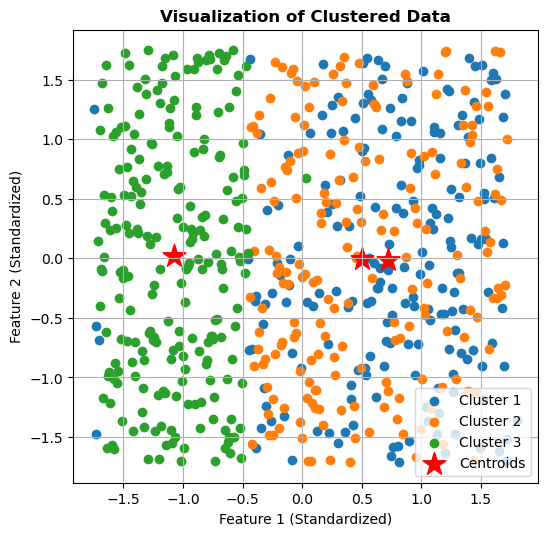

In [65]:
# Assuming 'data' is your DataFrame
scaler = StandardScaler() 
X_std = scaler.fit_transform(data)

# Apply K-Means clustering
km = KMeans(n_clusters=3, random_state=42) 
km.fit(X_std)
centroids = km.cluster_centers_

# Print centroids in scaled space
print("Centroids (scaled):")
print(centroids)

# Inverse transform centroids to original scale
original_centroids = scaler.inverse_transform(X_std)
print("Centroids (original scale):")
print(original_centroids)

# Print inertia
print("Inertia value is:", km.inertia_)

# Plot the clustered data
fig, ax = plt.subplots(figsize=(6, 6))
for i in range(3):  # Assuming 3 clusters
    plt.scatter(X_std[km.labels_ == i, 0], X_std[km.labels_ == i, 1],
                label=f'Cluster {i+1}')

# Plot centroids
plt.scatter(centroids[:, 0], centroids[:, 1], 
            marker='*', s=300, c='red', label='Centroids')

plt.legend()
plt.title('Visualization of Clustered Data', fontweight='bold')
plt.xlabel('Feature 1 (Standardized)')
plt.ylabel('Feature 2 (Standardized)')
ax.set_aspect('equal') 
plt.grid()
plt.show()

### FITTING

This graph shows the predictions using randomly selected values from the data and also shows the capability of the models to generalize and predict unseen data.

C:\Users\TECH\AppData\Local\Temp\ipykernel_12244\1964644907.py:17: OptimizeWarning: Covariance of the parameters could not be estimated
  p, cov = curve_fit(linfunc, x, y)


a = 1.00 +/- inf
b = -0.00 +/- inf
a = 0.00 +/- 0.00
b = 1.00 +/- 0.00
Random x: 37000
Prediction using curve_fit: 37000.0
Prediction using polyfit: 36999.999999999985


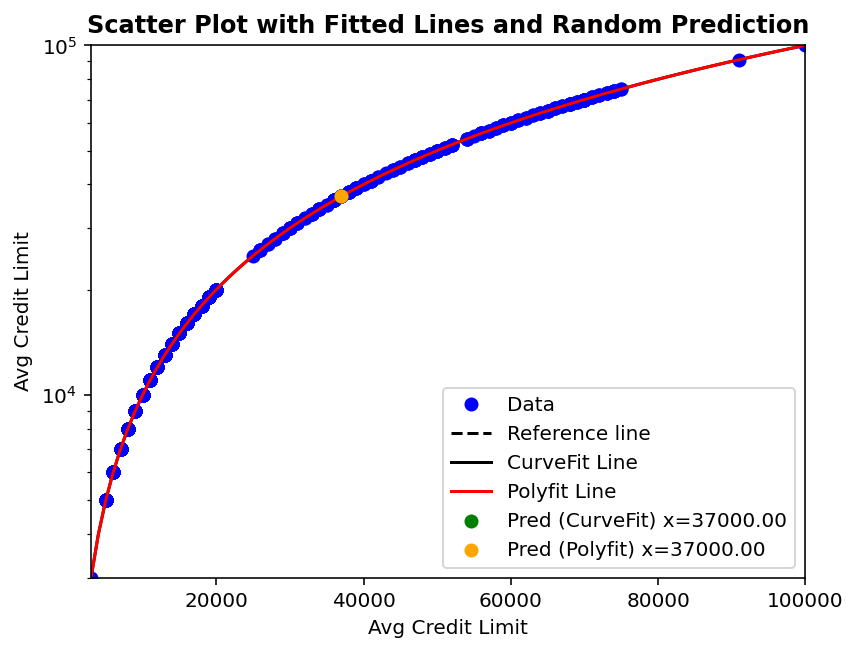

In [66]:
# Assuming 'data' is a DataFrame and you already have your x and y
x = data['Avg_Credit_Limit']
y = data['Avg_Credit_Limit']

# Line data (this is just for plotting a reference line)
xline = np.linspace(0, 1, 10)
yline = xline

# Define a linear function for fitting
def linfunc(x, a, b):
    """ Function for fitting a straight line, for curve_fit
    x: independent variable
    a, b: parameters to be fitted"""
    return a * x + b

# Fit the data with curve_fit
p, cov = curve_fit(linfunc, x, y)

# The errors are the square root of the diagonal of the covariance matrix
sigma = np.sqrt(np.diag(cov))
print(f"a = {p[0]:.2f} +/- {sigma[0]:.2f}")
print(f"b = {p[1]:.2f} +/- {sigma[1]:.2f}")

# Use numpy's polyfit for polynomial fitting
p_np, cov_np = np.polyfit(x, y, 1, cov=True)
sigma_np = np.sqrt(np.diag(cov_np))
b, a = p_np  # Note the coefficients returned by polyfit are in the order [slope, intercept]
print(f"a = {a:.2f} +/- {sigma_np[0]:.2f}")
print(f"b = {b:.2f} +/- {sigma_np[1]:.2f}")

# Function to make random predictions
def make_random_prediction(x, p, p_np):
    """ Takes random x from the data and makes predictions for both models """
    rand_index = np.random.randint(0, len(x))
    rand_x = x.iloc[rand_index]
    
    # Predict using curve_fit model (p)
    y_pred_curvefit = linfunc(rand_x, p[0], p[1])
    
    # Predict using numpy's polyfit model (p_np)
    y_pred_polyfit = np.polyval(p_np, rand_x)
    
    return rand_x, y_pred_curvefit, y_pred_polyfit

# Make random predictions
rand_x, y_pred_curvefit, y_pred_polyfit = make_random_prediction(x, p, p_np)
print(f"Random x: {rand_x}")
print(f"Prediction using curve_fit: {y_pred_curvefit}")
print(f"Prediction using polyfit: {y_pred_polyfit}")

# Plotting function
def plot_random_scatter_with_fitted_line(x, y, xline, yline, rand_x, y_pred_curvefit, y_pred_polyfit):
    """
    Creates a scatter plot of random x and y data with an overlaid fitted line
    Also includes predictions for a random x
    """
    plt.figure(dpi=144)
    # Scatter plot of the original data
    plt.plot(x, y, 'bo', label="Data")
    plt.plot(xline, yline, 'k--', label="Reference line")
    
    # Plot the fitted line using scipy's curve_fit
    xfit = np.linspace(np.min(x), np.max(x), 100)
    plt.plot(xfit, linfunc(xfit, p[0], p[1]), 'k-', label="CurveFit Line")
    
    # Error margins for the fitted line (based on standard deviation of the parameters)
    plt.fill_between(xfit, linfunc(xfit, p[0] - sigma[0], p[1] - sigma[1]),
                     linfunc(xfit, p[0] + sigma[0], p[1] + sigma[1]),
                     color='k', alpha=0.1)
    
    # Plot the fitted line using numpy's polyfit
    plt.plot(xfit, np.polyval(p_np, xfit), 'r-', label="Polyfit Line")
    
    # Highlight the random x and predictions
    plt.scatter(rand_x, y_pred_curvefit, color='green', zorder=5, label=f'Pred (CurveFit) x={rand_x:.2f}')
    plt.scatter(rand_x, y_pred_polyfit, color='orange', zorder=5, label=f'Pred (Polyfit) x={rand_x:.2f}')
    
    # Define plot limits
    plt.xlim(np.min(x) - 1, np.max(x) + 1)
    plt.ylim(np.min(y) - 1, np.max(y) + 1)

    # Set log scale for y axis if necessary
    plt.yscale('log')

    # Set plot labels and title
    plt.title('Scatter Plot with Fitted Lines and Random Prediction', fontsize=12, fontweight='bold')
    plt.xlabel('Avg Credit Limit')
    plt.ylabel('Avg Credit Limit')

    # Display the plot
    plt.legend()
    plt.show()

# Call the plot function
plot_random_scatter_with_fitted_line(x, y, xline, yline, rand_x, y_pred_curvefit, y_pred_polyfit)

# Adding Grouped value in the data set


Here, we shows the group values of clusters.

In [67]:
data['Group']=km.predict(X_std)
data['Group'].value_counts()


Group
2    222
0    198
1    190
Name: count, dtype: int64

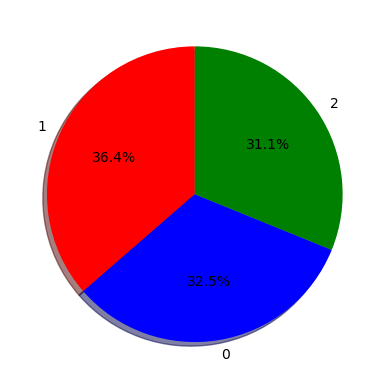

In [68]:
labels = [1, 0, 2]
values = data['Group'].value_counts().values
fig1, ax1 = plt.subplots()
colors = ['red', 'blue','green']
ax1.pie(values, labels=labels, autopct='%1.1f%%',shadow=True,startangle=90,colors=colors)
plt.show()

### Conclusion:

In this project, i performed K-Means Clustering by using elbow, silhoutte and random regression fitting models. In K-means i got 3 clusters. After performing the models, the customer segmentation we got in 3 groups.
Group 0 are those customers who are not spenders.
Group 1 are those customers who are are unable to spend as they do not have money.
Group 3 are those customers who are spenders.
By using this report analysis credit company can make better marketing strategies.